In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [ ]:
# Step 1: Load the data
# Ensure QVI_transaction_data.xlsx and QVI_purchase_behaviour.csv are in the same folder
transactions = pd.read_excel('QVI_transaction_data.xlsx')
customers = pd.read_csv('QVI_purchase_behaviour.csv')


In [ ]:
# Step 2: Explore transaction data
print("First 5 rows of Transaction Data:")
print(transactions.head())
print("\nTransaction Data Info:")
print(transactions.info())
print("\nTransaction Data Summary Statistics:")
print(transactions.describe())

First 5 rows of Transaction Data:
    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8  

Transaction Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   ---

In [ ]:
# Step 3: Clean transaction data
# Check for missing values
print("\nMissing Values in Transactions:")
print(transactions.isnull().sum())


Missing Values in Transactions:
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


In [ ]:
# Convert DATE from Excel serial format to datetime (e.g., 43390 -> 2018-07-01)
transactions['DATE'] = pd.to_datetime(transactions['DATE'], unit='D', origin='1899-12-30')
print("\nData type of DATE column after conversion:")
print(transactions['DATE'].dtype)


Data type of DATE column after conversion:
datetime64[ns]


In [ ]:
# Filter for chip products using positive keywords
chip_keywords = ['Chip', 'Chips', 'Crisps', 'Crinkle', 'Tortilla', 'Twisties', 'Cheezels', 'Corn']
transactions['IS_CHIP'] = transactions['PROD_NAME'].str.contains('|'.join(chip_keywords), case=False, na=False)
transactions_cleaned = transactions[transactions['IS_CHIP']].copy()

In [ ]:
# Handle outliers: Remove transactions with PROD_QTY > 5 (e.g., bulk purchases)
print("\nPROD_QTY Distribution Before Cleaning:")
print(transactions_cleaned['PROD_QTY'].describe())
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=transactions_cleaned['PROD_QTY'])
plt.title('Box Plot of PROD_QTY')
plt.subplot(1, 2, 2)
sns.histplot(transactions_cleaned['PROD_QTY'], bins=20, kde=True)
plt.title('Histogram of PROD_QTY')
plt.tight_layout()
plt.savefig('prod_qty_distribution.png')
plt.close()

transactions_cleaned = transactions_cleaned[transactions_cleaned['PROD_QTY'] <= 5].copy()
print("\nShape after removing outliers:", transactions_cleaned.shape)


PROD_QTY Distribution Before Cleaning:
count    128847.000000
mean          1.908411
std           0.852384
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64

Shape after removing outliers: (128845, 9)


In [ ]:
# Step 4: Derive features
# Extract pack size (e.g., '175g' -> 175)
def extract_pack_size(name):
    match = re.search(r'(\d+)(g|G)', name)
    return int(match.group(1)) if match else None

In [ ]:
transactions_cleaned['PACK_SIZE'] = transactions_cleaned['PROD_NAME'].apply(extract_pack_size)
print("\nMissing PACK_SIZE values:", transactions_cleaned['PACK_SIZE'].isnull().sum())
# Drop rows with missing PACK_SIZE
transactions_cleaned = transactions_cleaned.dropna(subset=['PACK_SIZE'])


Missing PACK_SIZE values: 0


In [ ]:
# Extract and standardize brand
transactions_cleaned['BRAND'] = transactions_cleaned['PROD_NAME'].str.split().str[0]
transactions_cleaned['BRAND'] = transactions_cleaned['BRAND'].replace({
    'Dorito': 'Doritos', 'Smith': 'Smiths', 'Infzns': 'Infuzions', 'WW': 'Woolworths',
    'RRD': 'Red Rock Deli', 'GrnWves': 'Grain Waves', 'Snbts': 'Sunbites', 'Natural': 'Natural Chip Co'
})
print("\nUnique Brands:", transactions_cleaned['BRAND'].unique())


Unique Brands: ['Natural Chip Co' 'Smiths' 'Kettle' 'Doritos' 'Twisties' 'Woolworths'
 'Thins' 'Cheezels' 'Tyrrells' 'Cobs' 'French' 'Pringles' 'Tostitos'
 'Sunbites']


In [ ]:
# Step 5: Explore customer data
print("\nFirst 5 rows of Customer Data:")
print(customers.head())
print("\nCustomer Data Info:")
print(customers.info())
print("\nMissing Values in Customers:")
print(customers.isnull().sum())


First 5 rows of Customer Data:
   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream

Customer Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

Missing Values in Customers:
LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


In [ ]:
# Step 6: Merge datasets
merged_data = pd.merge(transactions_cleaned, customers, on='LYLTY_CARD_NBR', how='left')
print("\nMissing Values in Merged Data:")
print(merged_data.isnull().sum())
merged_data = merged_data.dropna(subset=['LIFESTAGE', 'PREMIUM_CUSTOMER'])


Missing Values in Merged Data:
DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
IS_CHIP             0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


In [ ]:
# Step 7: Calculate metrics
total_sales_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
purchase_frequency_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TXN_ID'].count().reset_index()
purchase_frequency_by_segment.rename(columns={'TXN_ID': 'TRANSACTION_COUNT'}, inplace=True)
merged_data['AVG_SPEND_PER_UNIT'] = merged_data['TOT_SALES'] / merged_data['PROD_QTY']
average_spend_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['AVG_SPEND_PER_UNIT'].mean().reset_index()
brand_sales = merged_data.groupby('BRAND')['TOT_SALES'].sum().reset_index()


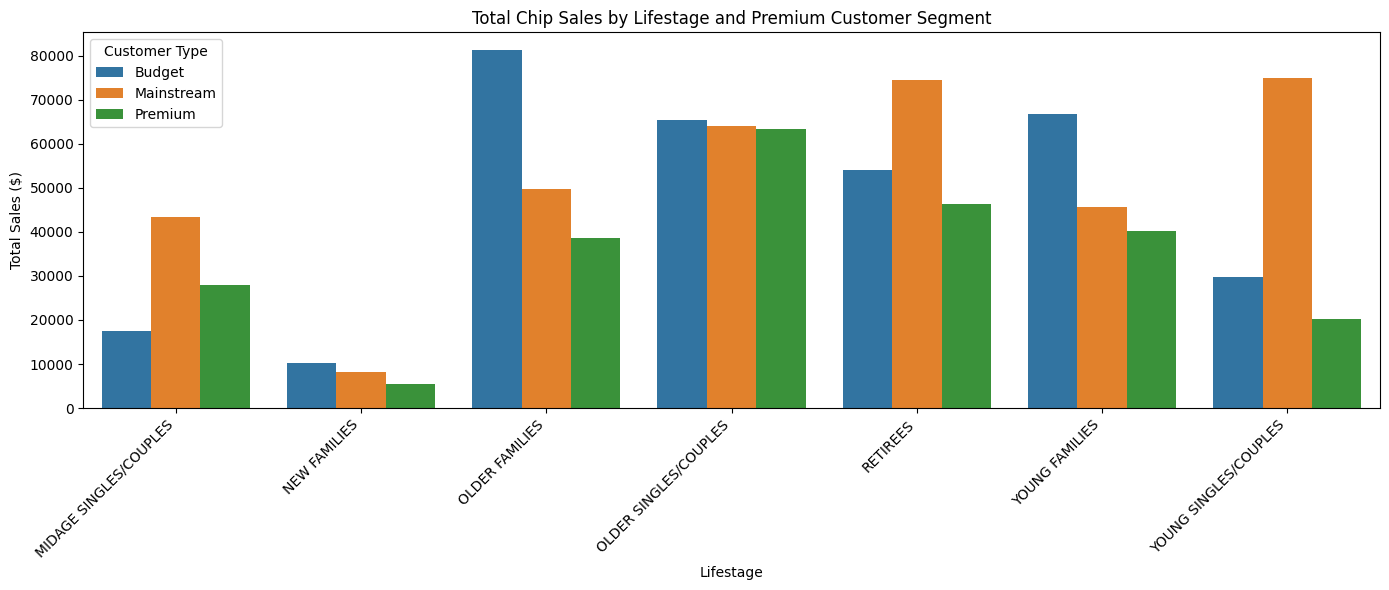

In [ ]:
# Step 8: Visualize insights
# Plot 1: Total sales by customer segment
plt.figure(figsize=(14, 6))
sns.barplot(data=total_sales_by_segment, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER')
plt.title('Total Chip Sales by Lifestage and Premium Customer Segment')
plt.xlabel('Lifestage')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()

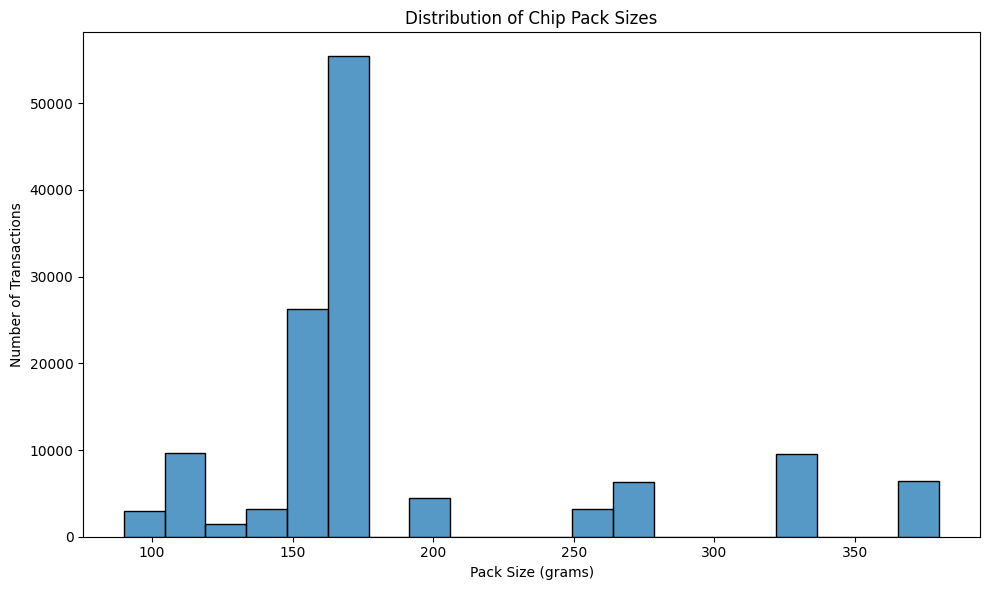

In [ ]:
# Plot 2: Pack size distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_data, x='PACK_SIZE', bins=20, edgecolor='black')
plt.title('Distribution of Chip Pack Sizes')
plt.xlabel('Pack Size (grams)')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()


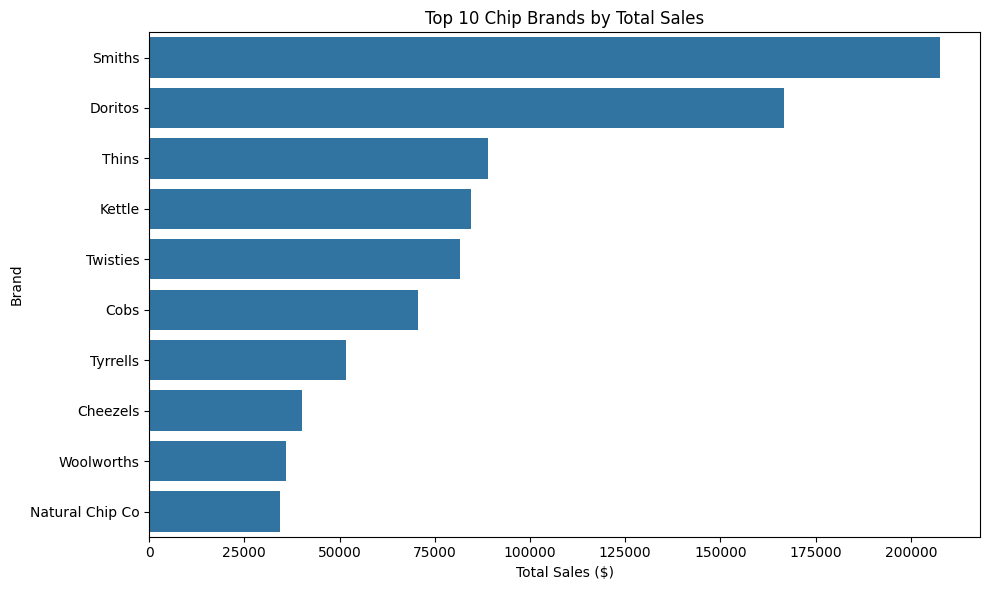

In [ ]:
# Plot 3: Top 10 brands by sales
plt.figure(figsize=(10, 6))
sns.barplot(data=brand_sales.sort_values('TOT_SALES', ascending=False).head(10), x='TOT_SALES', y='BRAND')
plt.title('Top 10 Chip Brands by Total Sales')
plt.xlabel('Total Sales ($)')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

In [ ]:
# Step 9: Save outputs
merged_data.to_csv('cleaned_merged_data.csv', index=False)
total_sales_by_segment.to_csv('total_sales_by_segment.csv', index=False)
purchase_frequency_by_segment.to_csv('purchase_frequency_by_segment.csv', index=False)
average_spend_by_segment.to_csv('average_spend_by_segment.csv', index=False)
brand_sales.to_csv('brand_sales.csv', index=False)

print("Analysis complete! CSVs and PNGs saved.")
print("To submit to Quantium, run this in Jupyter Notebook and export as PDF (File > Download as > PDF via LaTeX).")
print("Ensure pandoc and MiKTeX are installed for PDF export.")

Analysis complete! CSVs and PNGs saved.
To submit to Quantium, run this in Jupyter Notebook and export as PDF (File > Download as > PDF via LaTeX).
Ensure pandoc and MiKTeX are installed for PDF export.


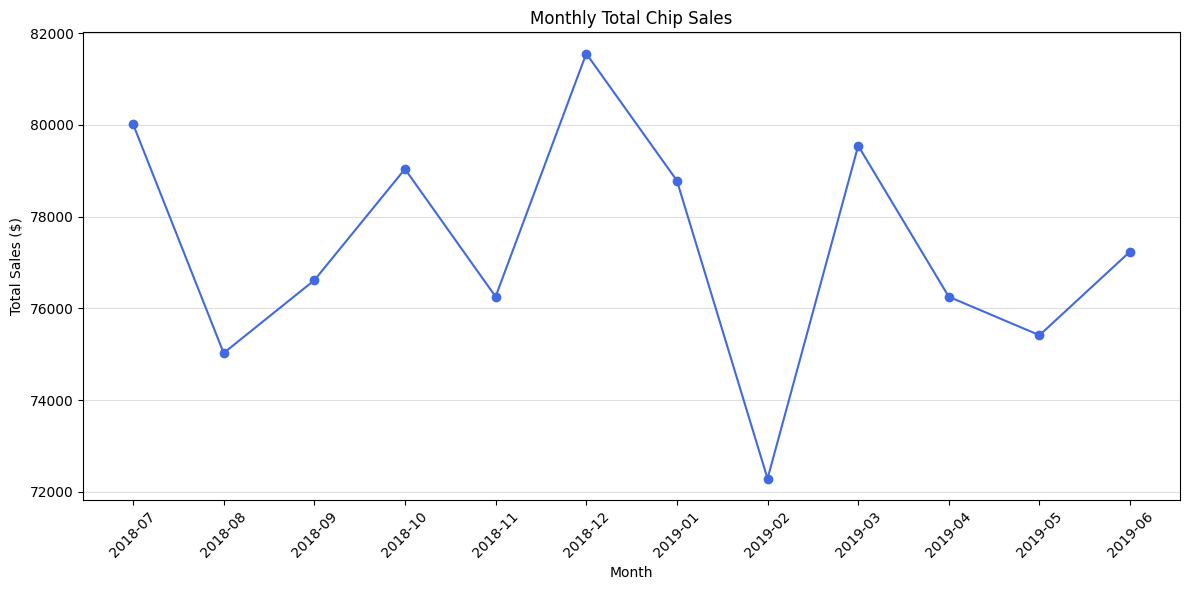

In [ ]:
monthly_sales = merged_data.groupby(merged_data['DATE'].dt.to_period("M"))['TOT_SALES'].sum().reset_index()
monthly_sales['DATE'] = monthly_sales['DATE'].astype(str)

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['DATE'], monthly_sales['TOT_SALES'], marker='o', color='royalblue')
plt.title("Monthly Total Chip Sales")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.savefig("monthly_total_sales.png", dpi=300)
plt.show()

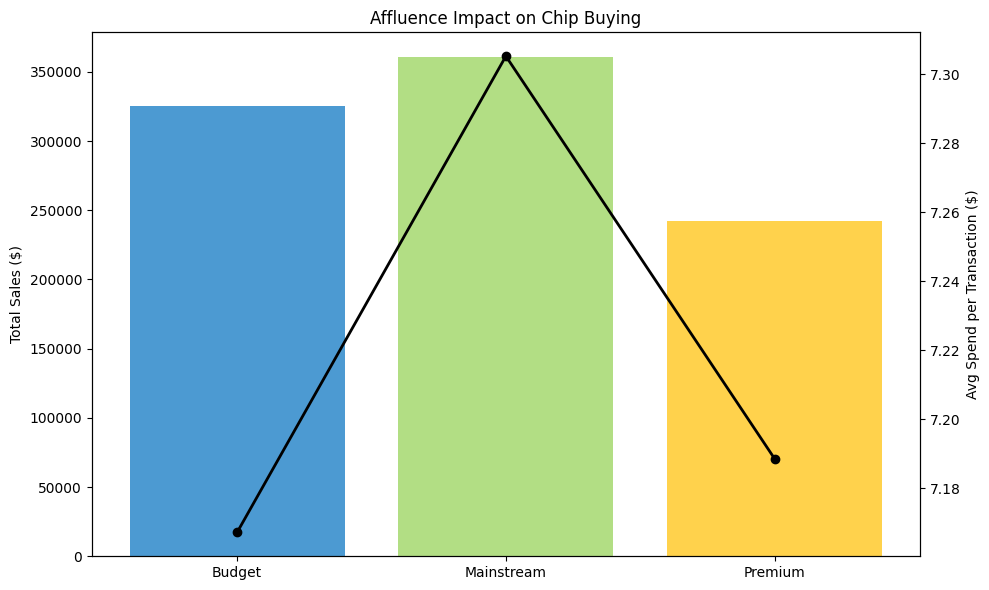

In [ ]:
# 2. Affluence Impact on Buying (Premium/Mainstream/Budget)
affluence_sales = merged_data.groupby("PREMIUM_CUSTOMER")['TOT_SALES'].sum().reset_index()
affluence_txn = merged_data.groupby("PREMIUM_CUSTOMER")['TXN_ID'].nunique().reset_index()
affluence = pd.merge(affluence_sales, affluence_txn, on="PREMIUM_CUSTOMER")
affluence.rename(columns={"TXN_ID":"TRANSACTIONS"}, inplace=True)
affluence['AVG_SPEND_PER_TXN'] = affluence['TOT_SALES'] / affluence['TRANSACTIONS']

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(affluence['PREMIUM_CUSTOMER'], affluence['TOT_SALES'], color=['#0070C0','#92D050','#FFC000'], alpha=0.7)
ax1.set_ylabel("Total Sales ($)")

ax2 = ax1.twinx()
ax2.plot(affluence['PREMIUM_CUSTOMER'], affluence['AVG_SPEND_PER_TXN'], color='black', marker='o', linewidth=2)
ax2.set_ylabel("Avg Spend per Transaction ($)")

plt.title("Affluence Impact on Chip Buying")
plt.tight_layout()
plt.savefig("affluence_sales_and_avgspend.png", dpi=300)
plt.show()


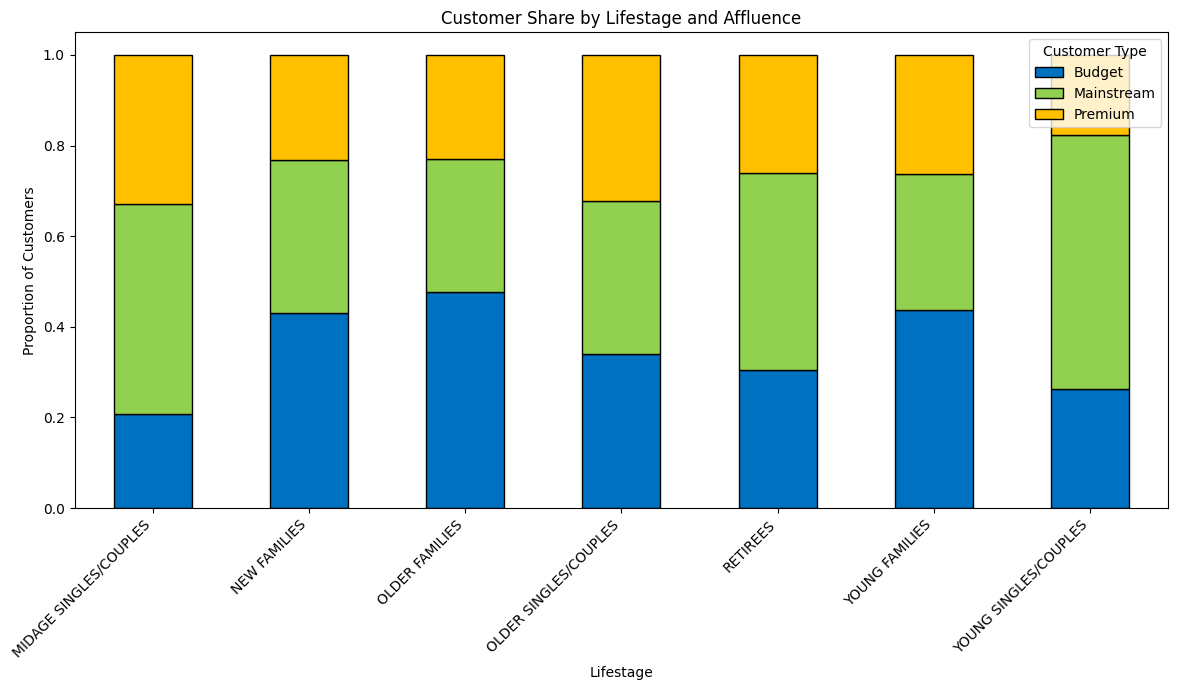

In [ ]:
# 3. Lifestage × Affluence – Customer Share (Stacked Bar)
cust_mix = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])['LYLTY_CARD_NBR'].nunique().reset_index()
pivot = cust_mix.pivot(index="LIFESTAGE", columns="PREMIUM_CUSTOMER", values="LYLTY_CARD_NBR").fillna(0)
pivot = pivot.div(pivot.sum(axis=1), axis=0)

pivot.plot(kind="bar", stacked=True, figsize=(12,7),
           color=['#0070C0','#92D050','#FFC000'], edgecolor="black")
plt.title("Customer Share by Lifestage and Affluence")
plt.xlabel("Lifestage")
plt.ylabel("Proportion of Customers")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Customer Type")
plt.tight_layout()
plt.savefig("lifestage_affluence_share.png", dpi=300)
plt.show()

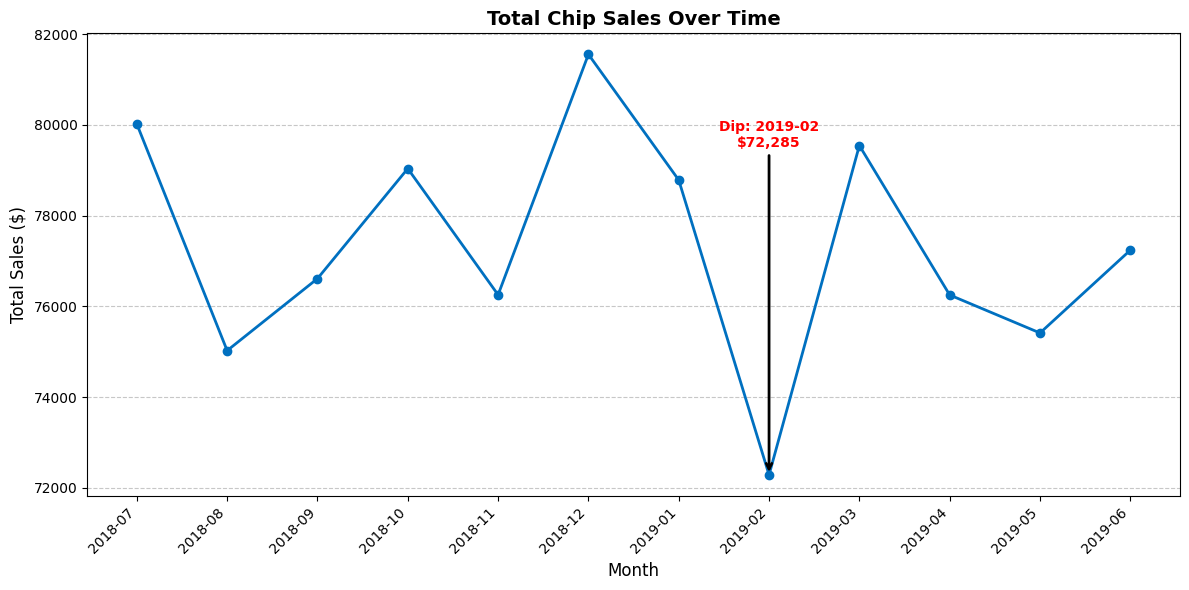

In [ ]:
merged_data["DATE"] = pd.to_datetime(merged_data["DATE"])
monthly_sales = (
    merged_data.groupby(merged_data["DATE"].dt.to_period("M"))["TOT_SALES"]
    .sum()
    .reset_index()
)
monthly_sales["DATE"] = monthly_sales["DATE"].astype(str)

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_sales["DATE"],
    monthly_sales["TOT_SALES"],
    color="#0070C0",
    marker="o",
    linewidth=2
)

plt.title("Total Chip Sales Over Time", fontsize=14, weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales ($)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Find the month with lowest sales (dip)
dip_idx = monthly_sales["TOT_SALES"].idxmin()
dip_month = monthly_sales.loc[dip_idx, "DATE"]
dip_value = monthly_sales.loc[dip_idx, "TOT_SALES"]

# Annotate the dip
plt.annotate(
    f"Dip: {dip_month}\n${dip_value:,.0f}",
    xy=(dip_idx, dip_value),
    xytext=(dip_idx, dip_value + dip_value*0.1),
    arrowprops=dict(facecolor="red", arrowstyle="->", lw=2),
    ha="center",
    fontsize=10,
    weight="bold",
    color="red"
)

plt.tight_layout()
plt.savefig("slide3_sales_trend_with_dip.png", dpi=300)
plt.show()